In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

In [191]:
df = pd.read_csv("f1_monaco_2024_cleaned.csv")
df.head()

,Driver,DriverName,Team,Session,LapNumber,Stint,Compound,LapTime_s,Sector1Time_s,Sector2Time_s,Sector3Time_s
0,VER,VER,Red Bull Racing,FP1,1.0,1.0,MEDIUM,102.030,28.052,49.466,24.512
1,VER,VER,Red Bull Racing,FP1,2.0,1.0,MEDIUM,78.049,20.929,36.583,20.537
2,VER,VER,Red Bull Racing,FP1,3.0,1.0,MEDIUM,100.449,25.065,49.473,25.911
3,VER,VER,Red Bull Racing,FP1,4.0,1.0,MEDIUM,75.625,20.154,35.585,19.886
4,VER,VER,Red Bull Racing,FP1,5.0,1.0,MEDIUM,97.846,25.751,50.907,21.188


In [192]:
# average lap and sector pace per driver from 2024 Monaco dataset
driver_features = df.groupby("Driver").agg({
    "LapTime_s": "mean",
    "Sector1Time_s": "mean",
    "Sector2Time_s": "mean",
    "Sector3Time_s": "mean"
}).reset_index()

driver_features.rename(columns={
    "LapTime_s": "AvgLapTime_2024",
    "Sector1Time_s": "AvgS1_2024",
    "Sector2Time_s": "AvgS2_2024",
    "Sector3Time_s": "AvgS3_2024"
}, inplace=True)

driver_features["TotalSector_2024"] = (
    driver_features["AvgS1_2024"] +
    driver_features["AvgS2_2024"] +
    driver_features["AvgS3_2024"]
)

driver_features

,Driver,AvgLapTime_2024,AvgS1_2024,AvgS2_2024,AvgS3_2024,TotalSector_2024
0,ALB,84.666653,22.275968,38.690858,23.699826,84.666653
1,ALO,84.148586,21.944426,38.579463,23.624698,84.148586
2,BOT,85.195565,22.336522,39.403964,23.455080,85.195565
3,GAS,84.831669,22.727914,38.867540,23.236215,84.831669
4,HAM,84.386833,22.373289,39.059850,22.953694,84.386833
5,HUL,88.911313,23.679808,40.767768,24.463737,88.911313
6,LEC,84.673560,21.869560,38.611554,24.192446,84.673560
7,MAG,88.422010,23.490240,40.358720,24.573050,88.422010
8,NOR,83.178400,21.734711,38.288244,23.155444,83.178400
9,OCO,86.206310,22.916230,39.010640,24.279440,86.206310


In [193]:
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime": [70.669, 69.954, 70.129, 71.500, 71.362, 71.213,
                       70.063, 70.942, 70.382, 72.563, 71.994, 70.924, 71.596]
})


In [194]:
# clean air race pace from Monaco 2024 (example values)
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600,
    "ALO": 94.784333, "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444,
    "STR": 95.318250, "HUL": 95.345455, "OCO": 95.682128, "ALB": 95.800000,
    "GAS": 95.900000
}

# Map driver to team
driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren",
    "RUS": "Mercedes", "HAM": "Mercedes", "LEC": "Ferrari",
    "SAI": "Ferrari", "ALO": "Aston Martin", "STR": "Aston Martin",
    "OCO": "Alpine", "GAS": "Alpine", "HUL": "Haas",
    "ALB": "Williams"
}

# Constructor points for 2025 prediction baseline (example)
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull": 131,
    "Williams": 51, "Ferrari": 114, "Haas": 20,
    "Aston Martin": 14, "Alpine": 7
}

max_points = max(team_points.values())
team_performance_score = {team: pts / max_points for team, pts in team_points.items()}

# historical average Monaco quali-to-race position change
average_position_change_monaco = {
    "VER": -1.0, "NOR": 1.0, "PIA": 0.2, "RUS": 0.5, "SAI": -0.3,
    "ALB": 0.8, "LEC": -1.5, "OCO": -0.2, "HAM": 0.3,
    "STR": 1.1, "GAS": -0.4, "ALO": -0.6, "HUL": 0.0
}


In [195]:
qualifying_2025["CleanAirRacePace_2024"] = qualifying_2025["Driver"].map(clean_air_race_pace)
qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)
qualifying_2025["AvgPosChange_Monaco"] = qualifying_2025["Driver"].map(average_position_change_monaco)


In [196]:
qualifying_2025["RainProb"] = 0.1
qualifying_2025["Temp"] = 25


In [197]:
data = qualifying_2025.merge(driver_features, on="Driver", how="left")
data


,Driver,QualifyingTime,CleanAirRacePace_2024,Team,TeamPerformanceScore,AvgPosChange_Monaco,RainProb,Temp,AvgLapTime_2024,AvgS1_2024,AvgS2_2024,AvgS3_2024,TotalSector_2024
0,VER,70.669,93.191067,Red Bull,0.469534,-1.0,0.1,25,84.222574,22.014716,38.672098,23.535760,84.222574
1,NOR,69.954,93.428600,McLaren,1.000000,1.0,0.1,25,83.178400,21.734711,38.288244,23.155444,83.178400
2,PIA,70.129,93.232111,McLaren,1.000000,0.2,0.1,25,83.468874,21.842023,38.183351,23.443500,83.468874
3,RUS,71.500,93.833378,Mercedes,0.526882,0.5,0.1,25,84.901647,22.369535,39.153701,23.378412,84.901647
4,SAI,71.362,94.497444,Ferrari,0.408602,-0.3,0.1,25,86.530310,22.782465,39.804620,23.943225,86.530310
5,ALB,71.213,95.800000,Williams,0.182796,0.8,0.1,25,84.666653,22.275968,38.690858,23.699826,84.666653
6,LEC,70.063,93.418667,Ferrari,0.408602,-1.5,0.1,25,84.673560,21.869560,38.611554,24.192446,84.673560
7,OCO,70.942,95.682128,Alpine,0.025090,-0.2,0.1,25,86.206310,22.916230,39.010640,24.279440,86.206310
8,HAM,70.382,94.020622,Mercedes,0.526882,0.3,0.1,25,84.386833,22.373289,39.059850,22.953694,84.386833
9,STR,72.563,95.318250,Aston Martin,0.050179,1.1,0.1,25,85.907484,22.818307,39.581569,23.507608,85.907484


In [198]:
features = ["QualifyingTime", "RainProb", "Temp",
            "TeamPerformanceScore", "CleanAirRacePace_2024",
            "AvgPosChange_Monaco", "TotalSector_2024"]

X = data[features]
y = data["AvgLapTime_2024"]

imp = SimpleImputer(strategy="median")
X = imp.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

data["PredictedRacePace_2025"] = model.predict(imp.transform(data[features]))


In [199]:
result = data.sort_values("PredictedRacePace_2025")
result[["Driver","PredictedRacePace_2025"]]


,Driver,PredictedRacePace_2025
1,NOR,83.178466
2,PIA,83.468920
5,ALB,84.666684
11,ALO,84.671073
6,LEC,84.673578
8,HAM,84.685650
0,VER,84.685681
10,GAS,84.831674
3,RUS,84.901638
7,OCO,86.206287


In [200]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.9236553413831956


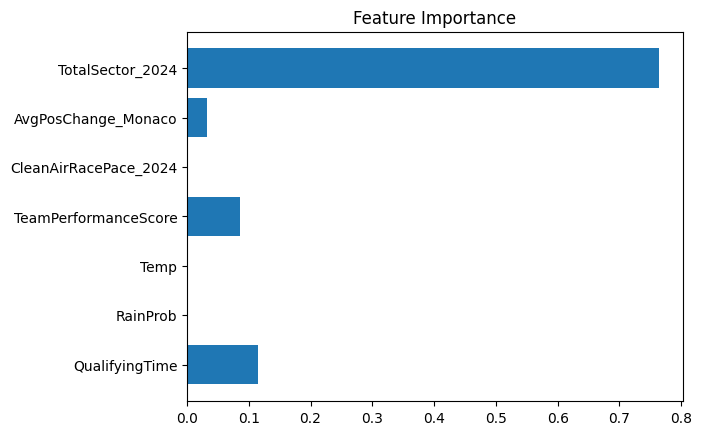

In [201]:
plt.barh(features, model.feature_importances_)
plt.title("Feature Importance")
plt.show()